In [9]:
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
#from astroquery.simbad import Simbad
from tqdm import tqdm
from astropy.coordinates import SkyCoord
#from astroquery.gaia import Gaia
import astropy.units as u
import astropy
from astropy.table import Table
from bisect import bisect_left
import sys

from PyAstronomy import pyasl

halpha = 6564.61
speed_light = 299792458

import lmfit
from scipy.interpolate import interp1d
sys.path.append('../../../wdtools/')
import wdtools
sys.path.append('../../../')
import WD_models
import pickle

import matplotlib
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

# Skip down to 'Load Data' unless you want to de-redden and fit Balmer parameters again

#### Plot CMD

#### Get Data

#### De-reddening

#### Get Balmer Parameters

In [28]:
def get_spectrum(source_id):
    path = '../../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except KeyboardInterrupt:
        raise
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

# Load Data

In [46]:
table = Table.read('tables/xmatch_dereddened.fits')

goodpar = (table['parallax_over_error'] > 10) * (table['visibility_periods_used'] > 8) *\
                (table['astrometric_sigma5d_max'] < 1.)
anysda = ['sdA' in i for i in table['ty']]
wd = ['DA' == i for i in table['ty']]

print(len(table))
print(len(table[goodpar]))

14522
1807


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


[16.876 16.005 15.764 15.69  15.715]


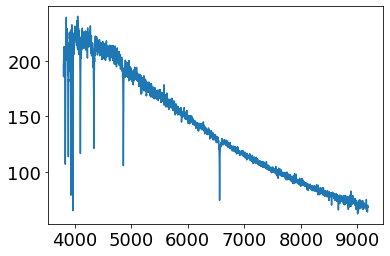

In [125]:
mp = 76

phot = (np.array([table[goodpar*anysda][mp]['u_0'], table[goodpar*anysda][mp]['g_0'], 
                   table[goodpar*anysda][mp]['r_0'], table[goodpar*anysda][mp]['i_0'], table[goodpar*anysda][mp]['z_0']]))

print(phot)

wl, fl = get_spectrum(table[goodpar*anysda][mp]['source_id'])
plt.plot(wl, fl)

In [126]:
spec = np.vstack((wl, fl))
np.savetxt('../test_data/mpms_spec.txt', spec)
np.savetxt('../test_data/mpms_phot.txt', phot)

[18.36805001 17.93385001 17.96775001 18.05910001 18.20185   ]


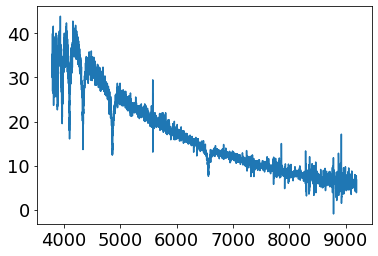

In [127]:
wdi = 6

phot = np.array([table[goodpar*wd][wdi]['u_0'], table[goodpar*wd][wdi]['g_0'], 
                   table[goodpar*wd][wdi]['r_0'], table[goodpar*wd][wdi]['i_0'], table[goodpar*wd][wdi]['z_0']])
print(phot)

wl, fl = get_spectrum(table[goodpar*wd][wdi]['source_id'])

plt.plot(wl, fl)

In [128]:
spec = np.vstack((wl, fl))
np.savetxt('../test_data/wd_spec.txt', spec)
np.savetxt('../test_data/wd_phot.txt', phot)

In [129]:
table[goodpar][1]['source_id']

3797635273107252096

In [7]:
len(table[goodpar*wd]) / len(table[goodpar])

0.659103486441616

In [8]:
len(table[goodpar*anysda]) / len(table[goodpar])

0.3408965135583841

In [4]:
param_df = pd.read_pickle('tables/pdf.p')

In [5]:
pure_sda = (table['ty'] == 'sdA/F') | (table['ty'] == 'DA') | (table['ty'] == 'sdA')

pdf = param_df

clean = (
    (pdf['a_fwhm'] < 75)&
    (pdf['d_fwhm'] < 75)&
    (pdf['g_fwhm'] < 75)&
    (pdf['b_fwhm'] < 75)&
    (pdf['a_height'] < 1)&
    (pdf['b_height'] < 1)&
    (pdf['g_height'] < 1)&
    (pdf['d_height'] < 1)
) & goodpar & pure_sda

wd = np.asarray(wd)

#cleantable = table
cleantable = table[np.asarray(clean)]

phot_X = np.array([cleantable['u_0'], cleantable['g_0'], 
                   cleantable['r_0'], cleantable['i_0'], cleantable['z_0']]).T
phot_X = np.diff(phot_X, axis =1)
phot_X_griz = np.array([cleantable['g_0'], cleantable['r_0'], cleantable['i_0'], cleantable['z_0']]).T
phot_X_griz = np.diff(phot_X_griz, axis =1)


spec_features = ['a_fwhm', 'a_height',
       'b_fwhm', 'b_height',
       'g_fwhm', 'g_height',
         'd_fwhm', 'd_height']

spec_X = pdf[clean][spec_features]
labels = np.zeros(len(wd))
labels[anysda] = 1
t = labels[clean]

X_combined = np.hstack((phot_X, spec_X))

## Get Classifiers

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix,precision_recall_curve, average_precision_score

lr_spec = pickle.load(open('LR/spec_lr.p', 'rb'))
lr_phot = pickle.load(open('LR/phot_lr.p', 'rb'))
lr_phot_griz = pickle.load(open('LR/phot_lr_griz.p', 'rb'))
lr_combined = pickle.load(open('LR/combined.p', 'rb'))

In [7]:
prob_spec = lr_spec.predict_proba(spec_X)[:, 1]
prob_phot = lr_phot.predict_proba(phot_X)[:, 1]
prob_phot_griz = lr_phot_griz.predict_proba(phot_X_griz)[:, 1]
prob_combined = lr_combined.predict_proba(X_combined)[:, 1]

spec_fpr, spec_tpr, _ = roc_curve(t, prob_spec)
phot_fpr, phot_tpr, _ = roc_curve(t, prob_phot)
griz_fpr, griz_tpr, _, = roc_curve(t, prob_phot_griz)

combined_fpr, combined_tpr, _ = roc_curve(t, prob_combined)

## ROC Curve

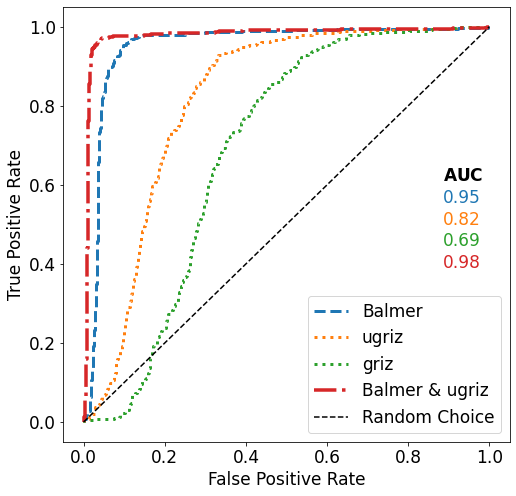

In [9]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize = (8,8))
c1 = 'C0'
c2 = 'C1'
c3 = 'C2'
c4 = 'C3'

plt.plot(spec_fpr, spec_tpr, label = 'Balmer', color = c1, linestyle = '--', linewidth = 3)
plt.plot(phot_fpr, phot_tpr, label = 'ugriz', color = c2, linestyle = ':', linewidth = 3)
plt.plot(griz_fpr, griz_tpr, label = 'griz', color = c3, linestyle = ':', linewidth = 3)
plt.plot(combined_fpr, combined_tpr, label = 'Balmer & ugriz', color = c4, linestyle = '-.', linewidth = 3.5)

x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle = '--', color = 'k', label = 'Random Choice')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

vdist = 0
plt.text(0.85, 0.6+vdist, r'$\bf{AUC}$', transform = plt.gca().transAxes)
plt.text(0.85, 0.55+vdist, '%.2f' % auc(spec_fpr, spec_tpr), transform = plt.gca().transAxes, color = c1)
plt.text(0.85, 0.5+vdist, '%.2f' % auc(phot_fpr, phot_tpr), transform = plt.gca().transAxes, color = c2)
plt.text(0.85, 0.45+vdist, '%.2f' % auc(griz_fpr, griz_tpr), transform = plt.gca().transAxes, color = c3)
plt.text(0.85, 0.4+vdist, '%.2f' % auc(combined_fpr, combined_tpr), transform = plt.gca().transAxes, color = c4)

perf_x = [0, 0, 1]
perf_y = [0, 1, 1]

#plt.plot(perf_x, perf_y, color = 'k', label = 'Perfect Classifier')

plt.legend()

plt.savefig('fig/lr_auc.pdf', bbox_inches = 'tight')

## PR Curve

In [10]:
spec_precision, spec_recall, _ = precision_recall_curve(t, prob_spec)
phot_precision, phot_recall, _ = precision_recall_curve(t, prob_phot)
griz_precision, griz_recall, _ = precision_recall_curve(t, prob_phot_griz)

combined_precision, combined_recall, combined_thresh = precision_recall_curve(t, prob_combined)

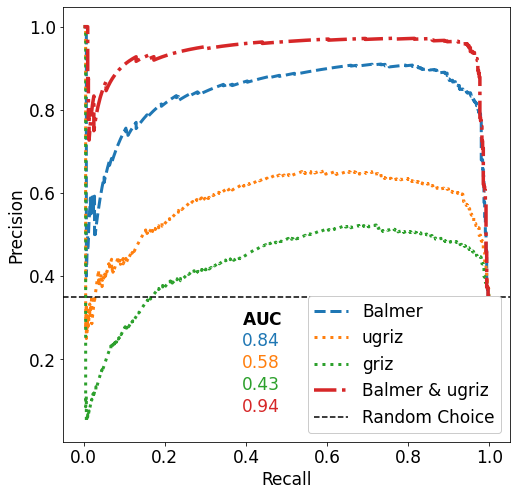

In [11]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize = (8,8))

plt.plot(spec_recall, spec_precision, label = 'Balmer', color = c1, linestyle = '--', linewidth = 3)
plt.plot(phot_recall, phot_precision, label = 'ugriz', color = c2, linestyle = ':', linewidth = 3)
plt.plot(griz_recall, griz_precision, label = 'griz', color = c3, linestyle = ':', linewidth = 3)
plt.plot(combined_recall, combined_precision, 
         label = 'Balmer & ugriz', color = c4, linestyle = '-.', linewidth = 3.5)

plt.xlabel('Recall')
plt.ylabel('Precision')

vdist = 0.07
plt.text(0.4, 0.2+vdist, r'$\bf{AUC}$', transform = plt.gca().transAxes)
plt.text(0.4, 0.15+vdist, '%.2f' % auc(spec_recall, spec_precision), transform = plt.gca().transAxes, color = c1)
plt.text(0.4, 0.1+vdist, '%.2f' % auc(phot_recall, phot_precision), transform = plt.gca().transAxes, color = c2)
plt.text(0.4, 0.05+vdist, '%.2f' % auc(griz_recall, griz_precision), transform = plt.gca().transAxes, color = c3)
plt.text(0.4, 0.0+vdist, '%.2f' % auc(combined_recall, combined_precision), 
         transform = plt.gca().transAxes, color = c4)

ratio = sum(t) / len(t)
plt.axhline(ratio, color = 'k', linestyle = '--', label = 'Random Choice')

plt.legend(loc = 4, framealpha = 1)

plt.savefig('fig/lr_pr.pdf', bbox_inches = 'tight')

## Apply to all stars and write classifications

In [12]:
clean = (
    (pdf['a_fwhm'] < 100)&
    (pdf['d_fwhm'] < 100)&
    (pdf['g_fwhm'] < 100)&
    (pdf['b_fwhm'] < 100)&
    (pdf['a_height'] < 1)&
    (pdf['b_height'] < 1)&
    (pdf['g_height'] < 1)&
    (pdf['d_height'] < 1)
) & pure_sda

sum(clean)

13378

In [13]:
cleantable = table[np.asarray(clean)]

phot_X = np.array([cleantable['u_0'], cleantable['g_0'], cleantable['r_0'], 
                   cleantable['i_0'], cleantable['z_0']]).T
phot_X = np.diff(phot_X, axis =1)

spec_X = pdf[clean][spec_features]

combined_X = np.hstack((phot_X, spec_X))

labels = np.zeros(len(wd))
labels[anysda] = 1
t = labels[clean]

In [14]:
prob_phot = lr_phot.predict_proba(phot_X)[:, 1]
prob_spec = lr_spec.predict_proba(spec_X)[:, 1]
prob_combined = lr_combined.predict_proba(combined_X)[:, 1]

cleantable['p_phot'] = prob_phot
cleantable['p_spec'] = prob_spec
cleantable['p_combined'] = prob_combined

In [15]:
threshold = 0.5
prediction = (prob_combined > threshold).astype(int)

np.sum(prediction == t) / len(t)

0.9382568395873823

(array([ 1909.,   279.,   178.,   106.,   106.,    93.,   131.,   184.,
          338., 10054.]),
 array([8.05714953e-21, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

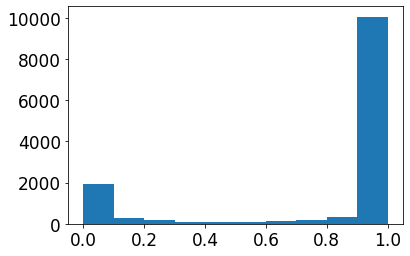

In [16]:
plt.hist(prob_combined)

In [80]:
cleantable.write('tables/lr_class.fits', overwrite = True)